In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [2]:
data_dir = "/Users/brucerowan/Documents/capstone/DigitalDemocracyCapstone/"
target_col = 'utterance_transition_values'

In [3]:
training_output_filename = data_dir  + "training_utterances.csv"


In [4]:
# split dataset evenly based on labels
def split_test_train(total, stratify_col):
    transition_rows = total[total[stratify_col] != 0]
    non_transition_rows = total[total[stratify_col] == 0]
    
    # first split transitions into training/testing
    X_train1, X_test1, y_train1, y_test1 = train_test_split(transition_rows, 
                                                    transition_rows[target_col], 
                                                    test_size=0.30, random_state=42)
    
    # assert there are only transition labels in this dataframe
    assert len(X_train1[X_train1[target_col] == 0]) == 0
    assert len(X_test1[X_test1[target_col] == 0]) == 0
    
    train_len = len(X_train1) # number of non-transitions to add to training set
    test_len = len(X_test1) # number of non-transitions to add to testing set
    
    
    # next split non-transitions into training/testing
    X_train2, X_test2, y_train2, y_test2 = train_test_split(non_transition_rows, 
                                                    non_transition_rows[target_col], 
                                                    test_size=0.30, random_state=42)
    
    # pick train_len random rows from non-transition training set
    ###change n = train_len
    print(train_len)
    X_train2 = X_train2.sample(n = train_len*1, axis=0)
    
    # pick test_len random rows from non_transitions testing set
    X_test2 = X_test2.sample(n = test_len, axis=0)
    
    # assert there are no transition utterances in non-transition training and testing set
    assert len(X_train2[X_train2[target_col] != 0]) == 0
    assert len(X_test2[X_test2[target_col] != 0]) == 0
    
    # final result, concat the dataframe
    X_train_final = pd.concat([X_train1, X_train2])
    X_test_final = pd.concat([X_test1, X_test2])
    return X_train_final['text'], X_test_final['text'], X_train_final[target_col], X_test_final[target_col]
    

In [5]:
data = pd.read_table(training_output_filename, sep = "~")
len(data[data[target_col]==1])

6244

In [6]:
train = pd.read_table(training_output_filename, sep="~")[['text', target_col]]

In [7]:
data = pd.read_table("training_utterances.csv",sep ='~')
data.head()

,start,end,text,video_id,utterance_transition_values
0,0,2,We don't have a quorum yet I don't believe.,4221,1
1,6,8,We don't have a quorum yet.,4221,0
2,8,13,We'll ask the sergeants to please call the mem...,4221,0
3,13,21,that we can establish a quorum for this partic...,4221,0
4,21,26,This is the Assembly's 2nd Extraordinary Sessi...,4221,0


In [8]:
#make all 2's into 1's
train.loc[train[target_col] > 0, target_col] = 1
train.columns

Index(['text', 'utterance_transition_values'], dtype='object')

In [9]:
x_train, x_test, y_train, y_test = split_test_train(train, target_col)

5226


In [10]:
len(x_train)

10452

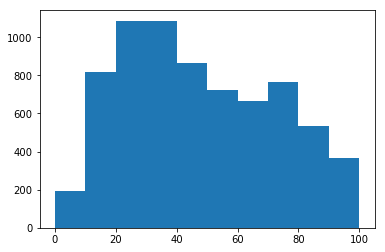

In [11]:
df = train.loc[train[target_col]==1]
lens = (df['text'].apply(len))
plt.hist(lens, range = (0,100))
plt.show()

In [12]:
# there are 5226 transition phrases and 5226*6 = 31356 non transition phrases
# 36582 total

In [13]:
transition_rows = train[train[target_col] != 0]
len(transition_rows)

7466

### Assert training and testing splits are the correct dimensions
### After splitting, training and testing sets should each have 50% transitions and 50% non-transitions
### training dimensions should be 2 * 70% of the number of transitions in the data set
### testing dimensions should be 2 * 30% of the number of transitions in the data set

In [14]:
len(train)

656444

In [15]:
assert len(x_train) == len(y_train)

In [16]:
assert len(x_test) == len(y_test)

In [17]:
assert len(x_train) == int(len(transition_rows) * 0.7) * 2

In [18]:
assert len(x_test) == (len(transition_rows) * 2) - (int(len(transition_rows) * 0.7) * 2)

In [19]:
assert len(y_train[y_train == 0]) == len(y_train[y_train != 0])

In [20]:
assert len(y_test[y_test == 0]) == len(y_test[y_test != 0])

### Vectorize utterances with bag of words features

In [21]:
count_vect = CountVectorizer()
count_vect.fit(np.hstack((x_train, x_test)))
X_train_counts = count_vect.transform(x_train)
X_test_counts = count_vect.transform(x_test)

In [22]:
assert X_train_counts.shape[1] == X_test_counts.shape[1]

### Pass vectorized utterances into a Naive Bayes model

In [23]:
clf = MultinomialNB()
clf.fit(X_train_counts, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Output accuracy on testing set

In [24]:
assert X_test_counts.shape[0] == y_test.shape[0]

In [25]:
clf.score(X_test_counts, y_test, sample_weight=None)

0.80602678571428577

In [471]:
nb_predictions =clf.predict(X_test_counts)
nb_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [473]:
wrong = 0
missed_transition = 0
for i in range(len(nb_predictions)):
    if nb_predictions[i] != y_test.iloc[i]:
        wrong= wrong+1
        print(nb_predictions[i],y_test.iloc[i],x_test.iloc[i])
        if nb_predictions[i] == 0:
            missed_transition = missed_transition +1 

0 1 Time frame for the commission to be able to release this transparency tool in terms of finances and it's very hard to say.
0 1 date of California's determinant sentencing statutes until January 1,
0 1 from school or six hundred-foot radius from school.
0 1 We want to hear how people cast their votes, so that's important, right?
0 1 are concurred in.
0 1 And I will keep it brief with that And this was heard in the other assembly committee the other day.
0 1 Garcia expands permissible activities of the Commission for Economic Development Holding Committee.
0 1 legislative season in california we currently have the practice
0 1 And If you'd start with stating that you will accept the amendments as proposed.
0 1 As soon as we have a quorum we will announce that.
0 1 depended upon an appropriation and that is done through the budget process
0 1 or treat mental health problems.
0 1 I'll ask staff to present the de Leon bills.
0 1 New item one, commission staffing, from the agenda and we 

0 1 o'brien there's a long list of people that are contributing to our community so
0 1 I have got more bill.
0 1 nine center jackson ...her death.
0 1 Mr. Chair and members, this bill is intended to address problems associated with the growing
0 1 We're going to leave the roll open to allow other members to add on.
0 1 This bill we heard last week, so I'd like to limit discussion on the amendments.
0 1 In essence, Elk Grove is
0 1 we be reimbursed for them that's what this bill does it takes care of them so I would ask your eye vote.
0 1 Under most of the resolutions colleagues.
0 1 This bill recognizes that children who have been both abused or neglected as well as removed from their home,
0 1 the last bill it ponder
0 1 ...any further debate or discussion on this item.
0 1 Yes. >> Santiago, aye.
0 1 taken into account when the
0 1 As where they're appearing.
0 1 they had no other recourse but to sue the department of finance well they did and they won now after the courts
0 1 We'll 

0 1 Let me just see here.
0 1 That's what's important about this bill.
0 1 Thank you so much.
0 1 Purpose of this bill is to give seniors in our state
0 1 I think I'll wait until later.
0 1 Yeah, 240.
0 1 That's right.
0 1 So, let's see, this is,
0 1 A young man was diagnosed.
0 1 year my father's currently suffering from terminal bone cancer?
0 1 Absolutely, without objection.
0 1 was given six months to live, came home.
0 1 small hospital in blight that often we'll see accidents that happen along
0 1 spent a lot of time working on this issue the fact is the
0 1 No file. >> Comments or questions from committee?
0 1 that had several other people have tried to pull this together and congratulations on fine effort here.
0 1 to vote, all members vote who desire to vote.
0 1 vote, but just something
0 1 To note, we have 64 bills to hear, 15 of those measures will be eligible for a vote.
0 1 open the roll, all
0 1 Did you have a higher level of living because you could afford to purchase mo

1 0 Thank you.
1 0 Lara?
1 0 Yeah okay, all right.
1 0 Thank you Assemblywoman.
1 0 Thank you, Mister Ting.
1 0 Thank you.
1 0 Allen.
1 0 Senate Bill 112.
1 0 Member as we are absent a quorum.
1 0 File items twenty-two through thirty
1 0 Thank you, please proceed.
1 0 No File.
1 0 Eduardo Garcia.
1 0 Senator Moorlach?
1 0 Patterson.
1 0 Ms. Garcia moves the call.
1 0 Thank you.
1 0 Great we got everybody, good hearing.
1 0 Pass on file.
1 0 By labor by ...
1 0 Members, going to file item 70.
1 0 There's a motion by Senator Leno.
1 0 Second.
1 0 knows thirteen the measure passes file item one ten senator leno
1 0 On the urgency, the ayes 67, nos 0, on the measure.
1 0 Jackson?
1 0 Bill. >> Second.
1 0 De Leon?
1 0 Item number 19, AB 2485, please call the absent members.
1 0 Lara.
1 0 affordability program to cover pre exposure prophylaxis related copays,
1 0 Okay
1 0 SB 1126, Senator Stone.
1 0 Senate bill 517 by Senator Monning, an act relating to supervised persons.
1 0 It's now in th

In [475]:
print(wrong)
print(missed_transition/wrong)

878
0.4612756264236902


## keras

In [409]:
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

## tokenize words

In [410]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [411]:
#so all utterences are same length
padded = pad_sequences(sequences, maxlen = 44)
print(padded.shape)

(20904, 44)


In [412]:
pred = to_categorical(y_train)
pred


array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [413]:
model = Sequential()
model.add(Embedding(20000, 150, input_length=44))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.5))
model.add(Dense(25,activation = 'sigmoid'))
model.add(Dense(2, activation='sigmoid')) #fully connected layer
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



In [414]:
#class weights 
class_weight = {
    0 : 1.,
    1: 3.,
    }

In [425]:
model.fit(padded, pred,validation_split=0.1, epochs = 1,class_weight = class_weight)


Train on 18813 samples, validate on 2091 samples
Epoch 1/1
18813/18813 [==============================] - 79s 4ms/step - loss: 0.5969 - acc: 0.8421 - val_loss: 0.4554 - val_acc: 0.8171


## testing 


In [426]:
tokenizer.fit_on_texts(x_test)
sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(sequences, maxlen = 44)
print(test_padded.shape)

(4480, 44)


In [427]:
predictions = model.predict(test_padded)
predictions = np.argmax(predictions, axis =1)
print(len(predictions))

4480


In [428]:
accuracy_score(predictions,y_test)


0.58303571428571432

In [424]:
#print(x_test.head(100))


In [466]:
wrong = 0
missed_transition = 0
for i in range(len(predictions)):
    if predictions[i] != y_test.iloc[i]:
        wrong= wrong+1
        print(predictions[i],y_test.iloc[i],x_test.iloc[i])
        if predictions[i] == 0:
            missed_transition = missed_transition +1 

0 1 We will now begin our special ceremony to commemorate LGBT Pride Month.
0 1 File items 112 and 113 we'll pass and retain.
0 1 Well, good afternoon, ladies and gentlemen.
0 1 Yes please begin.
0 1 Time frame for the commission to be able to release this transparency tool in terms of finances and it's very hard to say.
0 1 Miss Waldron, you may open.
0 1 date of California's determinant sentencing statutes until January 1,
0 1 Assembly Bill 566 by Assemblymember O'Donnell, an act relating to school facilities.
0 1 Thank you Vice Chair and Members.
0 1 Assembly Bill 1471, by Assembly member [UNKNOWN], an act related to business.
0 1 We want to hear how people cast their votes, so that's important, right?
0 1 And I will keep it brief with that And this was heard in the other assembly committee the other day.
0 1 Morning, Chair and Members.
0 1 ...vehicles senator canal ...president members this bill's a reduction of
0 1 We're good, thank you.
0 1 The clerk will read.
0 1 we're going to

0 1 [INAUDIBLE].
0 1 Thank you Chair and members.
0 1 Dr. Eggman.
0 1 This is also a bill with support on both sides.
0 1 Members we're going to return to privileges of the floor.
0 1 Pass on file.
0 1 And even if there is a delay, I think it's still a question for the legislature weighing that versus
0 1 Right. Thank you very much.
0 1 Thirty-five I know zero the resolution is adopted.
0 1 File Item 53, Senate Bill 215.
0 1 We open it on eight.
0 1 Assembly Bill 2798 will explicitly require the State's Energy Commission during the certification process
0 1 its employees as well as
0 1 Who's up next?
0 1 Thank you, Mr. Chair and members, I'm here to present AJR30 which calls on Congress to convene a constitutional convention for
0 1 Moving on to send it to third reading will be taking up file items
0 1 Clerk will read.
0 1 Good morning mr speaker members I'd like to introduce my guests who are here in the
0 1 The floor is yours.
0 1 That's 2031, but let's do them in order.
0 1 High eno

0 1 Mr. Secretary, please read.
0 1 We'll return to ...resolutions this is the opportunity for
0 1 Assembly Bill 2363 by Assembly Member Low, an act relating to state employment.
0 1 Assembly bill 1089, by Assembly member Eduardo Garcia, an act relating to the Coachella valley mount conservancy.
0 1 Waldren.
0 1 Thank you, Mr. President, Senators.
0 1 Collies we're going to be resuming action at this time if I could ask you
0 1 Moving out to Senator Leno.
0 1 We could pass.
0 1 Pass on file.
0 1 File item 55, Assembly Bill 1204, Chao. File item 55, Assembly Bill 1287, Chu.
0 1 Thank you Madam President, members.
0 1 law 854 by assembly member Weber an act relating to educational services.
0 1 File item 217 senate bill 671.
0 1 Leno, aye.
0 1 as soon as the pizza arrives, you have the floor.
0 1 We are going to call the meeting to order.
0 1 Thank you.
0 1 SB 80 is up next.
0 1 The clerk will...the I sixty-two...nine measure passes.
0 1 That bill has five.
0 1 for purposes of concurrent

0 1 Members we're back in session.
0 1 vote, but just something
0 1 motions and resolutions mr hold...ur recognize.
0 1 Assembly Bill 274 by the Committee on Environmental Safety & Toxic Materials inoculating the hazardous substances.
0 1 Pass on file.
0 1 To note, we have 64 bills to hear, 15 of those measures will be eligible for a vote.
0 1 [INAUDIBLE]
0 1 Did you have a higher level of living because you could afford to purchase more?
0 1 Unless you're just having fun Assemblymember Cooley, you've been here so
0 1 resolutions.
0 1 We are moving to file item 157, Senate Bill 319.
0 1 Assembly Bill 1509 by Assembly member Roger Hernandez, an Act relating to employment.
0 1 Thank you very much, Madam Chair and Senators.
0 1 Thank you, mister chair and members.
0 1 Assembly Bill 705 by Assemblymember Eggman, an act relating to psychologists.
0 1 Thank you members.
0 1 Good morning Mr. Chair and Members.
0 1 Assembly Bill 1993 by Assembly Member Irwin, enacted into law enforcement
0 1 P

1 0 much needed support to provide them an opportunity of a better life.
1 0 File Item 120, that's AB 2148, by Mister Holden.
1 0 Leno. >> Aye. Leno, aye.
1 0 Clerk will open the roll.
1 0 We have a motion on this bill.
1 0 There is no opposition to this bill, and I respectfully ask for your aye vote when you have a committee, or a quorum.
1 0 Any witnesses in opposition?
1 0 Those two payment metrics, in my recollection of the discussions were the two that it
1 0 And SP937, current vote is 12 to zero, absent member Galgiani.
1 0 The department has made great strives thanks to the work of the administration and
1 0 He was born in Mexico City just days before an almost 8.0 earthquake.
1 0 People are welcome to vote for it if they want.
1 0 All right, Senator Bates you have a question, right?
1 0 What that means is that, certainly unlike any other the part of board or
1 0 And so today, I have with me Kevin [UNKNOWN] of CCWRL and CAP Centre lane of the Welfare Directors Association.
1 0 A

1 0 Madam chair?
1 0 This bill would simply clarify the law in such a way that blesses this
1 0 Aye. Hertzberg.
1 0 Yeah, of course, you're welcome.
1 0 I'm calling to order today's informational hearing of the Public Health and
1 0 that is here present to that would like to add on support of the measure.
1 0 Morrell?
1 0 Thank you Mr. Obernote.
1 0 Thank you Mr. Secretary.
1 0 Lowe. >> No.
1 0 David Wolf with the Howard Jarvis Taxpayers Association we're in support of the bill and members,
1 0 Hueso.
1 0 Galgiani, aye.
1 0 Well, it doesn't help them negotiate the cost or bring the cost down.
1 0 or to build new facilities,
1 0 As the analysis points out, a lot of this is focused on the so called Pawlenty Plant at Oxnard.
1 0 Put it in in the summer, take it out when needed during the winter.
1 0 we believe that there are hospital closures that are happening around this state more often than not.
1 0 I very hill.
1 0 Hueso aye.
1 0 Aye, Huff?
1 0 Ok, the clerk will call close
1 0 Thank

In [467]:
print(wrong)
print(missed_transition)
print(missed_transition/wrong)


1868
1009
0.5401498929336188


## Notes
3 epochs seems to be the sweet spot

(using 6 times more non transitions)

model 1: 1 epochs, adam optimzer, class weights(0:1,1:6)
accuracy score: 58.06%, (61% guessed 0 when correct was 1)

model 1: 4 epochs, adam optimzer, class weights(0:1,1:6)
accuracy score: 53.46%, (72% guessed 0 when correct was 1)

model 1: 10 epochs, adam optimzer, class weights (0:1,1:6)
accuracy score: 53.31%, (61% guessed 0 when correct was 1)

model 1: 15 epochs, adam optimzer, class weights (0:1,1:6)
accuracy score: 53.15%, (71% guessed 0 when correct was 1)

model 1: 20 epochs, adam optimzer, class weights (0:1,1:6)
accuracy score: 51.36%, (69% guessed 0 when correct was 1)

model 1: 25 epochs, adam optimzer, class weights (0:1,1:6)
accuracy score: 52.83%, (67% guessed 0 when correct was 1)

model 1: 30 epochs, adam optimzer, class weights (0:1,1:6)
accuracy score: 51.65%, (73% guessed 0 when correct was 1)

model 1: 1 epochs, rmsprop, class weights (0:1,1:6)
accuracy score: 45.5%, (74% guessed 0 when correct was 1)

###model 2 

1 epoch, adam
accuracy score: 51.4%, (67.8% guessed 0 when correct was 1)

4 epochs, adam
accuracy score: 52.0%, (71.8% guessed 0 when correct was 1


### model1 
model = Sequential()
model.add(Embedding(20000, 150, input_length=44))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.5))
model.add(Dense(2, activation='sigmoid')) #fully connected layer
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


### model2 (remove conv layer and pooling layer)
model = Sequential()
model.add(Embedding(20000, 150, input_length=44))

model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.5))
model.add(Dense(2, activation='sigmoid')) #fully connected layer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



## model 3(model 1 with another dense layer) 59% acc on n_range data
model = Sequential()
model.add(Embedding(20000, 150, input_length=44))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.5))
model.add(Dense(25,activation = 'sigmoid'))
model.add(Dense(2, activation='sigmoid')) #fully connected layer
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
